# 1 Author

**Student Name**:  LuTianyu
**QM Student ID**:  210981405
**BUPT Student ID**:  2021213058

for more information about this project, please refer to my github project: https://github.com/laotianye01/ML_miniproject


# 2 Problem formulation

In the past, there are many picture which is taken without color, but today, with the help of nerval network, we can make them more colorful. In the following code, I will train a model which can generate a RGB picture of human face based on a gray picture.

# 3 Machine Learning pipeline

First, I will load the dataset. During that step, I will using a package call ColorThief to remove the color from the image as the predictor(original RGB image is ground truth). Then i will using my model to train. The training process uses the concept of GAN: The discriminator tries to distinguish between real and fake images while the generator tries to fool the discriminator by producing realistic fake images

# 4 Transformation stage

In this step, I transform the original image into the Gray pictures.

image shape: torch.Size([4, 3, 256, 256])
predictor_1 shape: torch.Size([4, 1, 256, 256])
predictor_2 shape: torch.Size([4, 2, 256, 256])


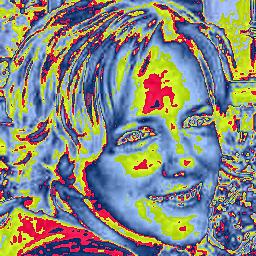

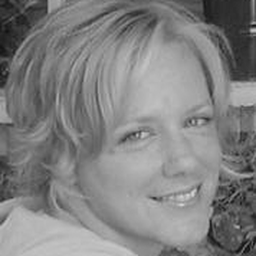

In [11]:
from torch.utils.data import DataLoader
from dataset import mydata
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import os
from PIL import Image

test_data_path = '/home/yelu/PycharmProjects/ml_minilab/self_supervise_dataset/genki4k/test'
km_file_path = "/home/yelu/PycharmProjects/ml_minilab/MemoPainter-PyTorch-master/pts_in_hull.npy"
tr_dataset = mydata(img_path=test_data_path, img_size=256, km_file_path=km_file_path, color_info='dist')
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=False, drop_last=True)
predictor = None
img = None
for i, batch in enumerate(tr_dataloader):
    to_pil_image = transforms.ToPILImage()
    img = to_pil_image(batch['res_input'][0])
    predictor = to_pil_image((batch['l_channel'] / 100.0)[0])
    print("image shape:", batch['res_input'].shape)
    print("predictor_1 shape:", batch['l_channel'].shape)
    print("predictor_2 shape:", batch['ab_channel'].shape)
    break

display(img)
display(predictor)

# 5 Modelling

The whole project is divided into two parts: memory network & generation network.



### 1.memory network
This external memory module to store critical information over long periods of time, it can provide top1_feature, a (313,) tensor, to GAN network.

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from ResNet import ResNet18
import numpy as np
from skimage.color import rgb2lab, deltaE_ciede2000

class Memory_Network(nn.Module):
    
    def __init__(self, mem_size, color_info, color_feat_dim=313, spatial_feat_dim=512, top_k=256, alpha=0.1, age_noise=4.0):
        
        super(Memory_Network, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.ResNet18 = ResNet18().to(self.device)
        self.ResNet18 = self.ResNet18.eval()
        self.mem_size = mem_size
        self.color_feat_dim = color_feat_dim
        self.spatial_feat_dim = spatial_feat_dim
        self.alpha = alpha
        self.age_noise = age_noise
        self.top_k = top_k
        self.color_info = color_info
        
        if self.color_info == 'dist':
            ## Each color_value is probability distribution
            self.color_value = F.normalize(random_uniform((self.mem_size, self.color_feat_dim), 0, 0.01), p = 1, dim=1).to(self.device)
        
        elif self.color_info == 'RGB':
            ## Each color_value is normalized RGB value [0, 1]
            self.color_value = random_uniform((self.mem_size, self.color_feat_dim), 0, 1).to(self.device)
        
        self.spatial_key = F.normalize(random_uniform((self.mem_size, self.spatial_feat_dim), -0.01, 0.01), dim=1).to(self.device)
        self.age = torch.zeros(self.mem_size).to(self.device)
        
        self.top_index = torch.zeros(self.mem_size).to(self.device)
        self.top_index = self.top_index - 1.0
        
        self.color_value.requires_grad = False
        self.spatial_key.requires_grad = False
        
        self.Linear = nn.Linear(512, spatial_feat_dim)
        self.body = [self.ResNet18, self.Linear]
        self.body = nn.Sequential(*self.body)
        
    def forward(self, x):
        q = self.body(x)
        q = F.normalize(q, dim = 1)
        return q
    
    def unsupervised_loss(self, query, color_feat, color_thres):
        bs = query.size()[0]
        cosine_score = torch.matmul(query, torch.t(self.spatial_key))
        top_k_score, top_k_index = torch.topk(cosine_score, self.top_k, 1)
        ### For unsupervised training
        color_value_expand = torch.unsqueeze(torch.t(self.color_value), 0)
        color_value_expand = torch.cat([color_value_expand[:,:,idx] for idx in top_k_index], dim = 0)
        color_feat_expand = torch.unsqueeze(color_feat, 2)
        color_feat_expand = torch.cat([color_feat_expand for _ in range(self.top_k)], dim = 2)
        if self.color_info == 'dist':
            color_similarity = self.KL_divergence(color_value_expand, color_feat_expand, 1)
        
        elif self.color_info == 'RGB':
            color_similarity = self.CIEDE2000(color_value_expand.cpu().numpy(), color_feat_expand.cpu().numpy())
        
        loss_mask = color_similarity < color_thres
        loss_mask = loss_mask.float()
        pos_score, pos_index = torch.topk(torch.mul(top_k_score, loss_mask), 1, dim = 1)
        neg_score, neg_index = torch.topk(torch.mul(top_k_score, 1 - loss_mask), 1, dim = 1)
        loss = self._unsupervised_loss(pos_score, neg_score)
        return loss
    
    def memory_update(self, query, color_feat, color_thres, top_index):
        cosine_score = torch.matmul(query, torch.t(self.spatial_key))
        top1_score, top1_index = torch.topk(cosine_score, 1, dim = 1)
        top1_index = top1_index[:, 0]
        top1_feature = self.spatial_key[top1_index]
        top1_color_value = self.color_value[top1_index]
        if self.color_info == 'dist':
            color_similarity = self.KL_divergence(top1_color_value, color_feat, 1)
            
        elif self.color_info == 'RGB':
            top1_color_value = top1_color_value.cpu().numpy()
            top1_color_value = np.expand_dims(top1_color_value, 2)
            color_feat_cpu = color_feat.cpu().numpy()
            color_feat_cpu = np.expand_dims(color_feat_cpu, 2)
            color_similarity = torch.squeeze(self.CIEDE2000(top1_color_value, color_feat_cpu))
        
        memory_mask = color_similarity < color_thres
        self.age = self.age + 1.0
        
        ## Case 1
        case_index = top1_index[memory_mask]
        self.spatial_key[case_index] = F.normalize(self.spatial_key[case_index] + query[memory_mask], dim = 1)
        self.age[case_index] = 0.0
        
        ## Case 2
        memory_mask = ~ memory_mask
        case_index = top1_index[memory_mask]
        
        random_noise = random_uniform((self.mem_size, 1), -self.age_noise, self.age_noise)[:, 0]
        random_noise = random_noise.to(self.device)
        age_with_noise = self.age + random_noise
        old_values, old_index = torch.topk(age_with_noise, len(case_index), dim=0)
        
        self.spatial_key[old_index] = query[memory_mask]
        self.color_value[old_index] = color_feat[memory_mask]
        self.top_index[old_index] = top_index[memory_mask]
        self.age[old_index] = 0.0
    
    def topk_feature(self, query, top_k = 1, device=None):
        _bs = query.size()[0]
        cosine_score = torch.matmul(query, torch.t(self.spatial_key))
        topk_score, topk_index = torch.topk(cosine_score, top_k, dim=1)
        if device is not None:
            topk_score, topk_index = topk_score.to(device), topk_index.to(device)
            self.color_value = self.color_value.to(device)
            self.top_index = self.top_index.to(device)

        topk_feat = torch.cat([torch.unsqueeze(self.color_value[topk_index[i], :], dim=0) for i in range(_bs)], dim=0)
        topk_idx = torch.cat([torch.unsqueeze(self.top_index[topk_index[i]], dim=0) for i in range(_bs)], dim=0)
        return topk_feat, topk_idx
    
    def KL_divergence(self, a, b, dim, eps = 1e-8):
        b = b + eps
        log_val = torch.log10(torch.div(a, b))
        kl_div = torch.mul(a, log_val)
        kl_div = torch.sum(kl_div, dim = dim)
        return kl_div
    
    def CIEDE2000(self, color_value_expand, color_feat_expand):
        bs, color_dim, num_top_k = color_value_expand.shape
        
        color_value_expand = np.transpose(color_value_expand, (0, 2, 1))
        color_feat_expand = np.transpose(color_feat_expand, (0, 2, 1))
        
        color_value_expand = np.reshape(color_value_expand, (bs, num_top_k, 3, 10))
        color_feat_expand = np.reshape(color_feat_expand, (bs, num_top_k, 3, 10))
        
        color_value_expand = np.transpose(color_value_expand, (0, 1, 3, 2))
        color_feat_expand = np.transpose(color_feat_expand, (0, 1, 3, 2))
        
        color_sim = [deltaE_ciede2000(rgb2lab(color_value_expand[i]), rgb2lab(color_feat_expand[i])) for i in range(bs)]
        color_sim = np.mean(np.array(color_sim), axis = 2)
        color_sim = torch.tensor(color_sim).to(self.device)
        color_sim.requires_grad = False
        return color_sim   
        
    def _unsupervised_loss(self, pos_score, neg_score):
        hinge = torch.clamp(neg_score - pos_score + self.alpha, min = 0.0)
        loss = torch.mean(hinge)   
        return loss   

def random_uniform(shape, low, high):
    x = torch.rand(*shape)
    result = (high - low) * x + low
    return result

### 2.generation network
This network take one channel gray pictures as input. It output a two channels tensor, combining it with the one channel image to generate the final output RGB image  

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class unet_generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf, color_dim = 313):
        super(unet_generator, self).__init__()
        
        self.e1 = nn.Conv2d(input_nc, ngf, 4, 2, 1)
        self.e2 = unet_encoder_block(ngf, ngf * 2)
        self.e3 = unet_encoder_block(ngf * 2, ngf * 4)
        self.e4 = unet_encoder_block(ngf * 4, ngf * 8)
        self.e5 = unet_encoder_block(ngf * 8, ngf * 8)
        self.e6 = unet_encoder_block(ngf * 8, ngf * 8)
        self.e7 = unet_encoder_block(ngf * 8, ngf * 8)
        self.e8 = unet_encoder_block(ngf * 8, ngf * 8, norm = None)

        self.d1 = unet_decoder_block(ngf * 8, ngf * 8)
        self.d2 = unet_decoder_block(ngf * 8 * 2, ngf * 8)
        self.d3 = unet_decoder_block(ngf * 8 * 2, ngf * 8)
        self.d4 = unet_decoder_block(ngf * 8 * 2, ngf * 8, drop_out = None)
        self.d5 = unet_decoder_block(ngf * 8 * 2, ngf * 4, drop_out = None)
        self.d6 = unet_decoder_block(ngf * 4 * 2, ngf * 2, drop_out = None)
        self.d7 = unet_decoder_block(ngf * 2 * 2, ngf, drop_out = None)
        self.d8 = unet_decoder_block(ngf * 2, output_nc, norm = None, drop_out = None)
        self.tanh = nn.Tanh()
        
        self.layers = [self.e1, self.e2, self.e3, self.e4, self.e5, self.e6, self.e7, self.e8,
                 self.d1, self.d2, self.d3, self.d4, self.d5, self.d6, self.d7, self.d8]
        
        self.mlp = MLP(color_dim, self.get_num_adain_params(self.layers), self.get_num_adain_params(self.layers), 3)
    
    def forward(self, x, color_feat):
        
        ### AdaIn params
        adain_params = self.mlp(color_feat)
        self.assign_adain_params(adain_params, self.layers)
        
        ### Encoder
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)
        e8 = self.e8(e7)
        
        ### Decoder
        d1_ = self.d1(e8)
        d1 = torch.cat([d1_, e7], dim = 1)
        
        d2_ = self.d2(d1)
        d2 = torch.cat([d2_, e6], dim = 1)
        
        d3_ = self.d3(d2)
        d3 = torch.cat([d3_, e5], dim = 1)
        
        d4_ = self.d4(d3)
        d4 = torch.cat([d4_, e4], dim = 1)
        
        d5_ = self.d5(d4)
        d5 = torch.cat([d5_, e3], dim = 1)
        
        d6_ = self.d6(d5)
        d6 = torch.cat([d6_, e2], dim = 1)

        d7_ = self.d7(d6)
        d7 = torch.cat([d7_, e1], dim = 1)
        
        d8 = self.d8(d7)
        output = self.tanh(d8) 
        return output
    
    def get_num_adain_params(self, _module):
        # return the number of AdaIN parameters needed by the model
        num_adain_params = 0
        for model in _module:
            for m in model.modules():
                if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                    num_adain_params += 2*m.num_features
        return num_adain_params
    
    def assign_adain_params(self, adain_params, _module):
        # assign the adain_params to the AdaIN layers in model
        for model in _module:
            for m in model.modules():
                if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                    mean = adain_params[:, :m.num_features]
                    std = adain_params[:, m.num_features:2*m.num_features]
                    m.bias = mean.contiguous().view(-1)
                    m.weight = std.contiguous().view(-1)
                    if adain_params.size(1) > 2*m.num_features:
                        adain_params = adain_params[:, 2*m.num_features:]
        
class unet_encoder_block(nn.Module):
    def __init__(self, input_nc, output_nc, ks = 4, stride = 2, padding = 1, norm = 'adain', act = nn.LeakyReLU(inplace = True, negative_slope = 0.2)):
        super(unet_encoder_block, self).__init__()
        self.conv = nn.Conv2d(input_nc, output_nc, ks, stride, padding)
        m = [act, self.conv]
        if norm == 'adain':
            m.append(AdaptiveInstanceNorm2d(output_nc))
        self.body = nn.Sequential(*m)
    
    def forward(self, x):
        return self.body(x)
    
class unet_decoder_block(nn.Module):
    def __init__(self, input_nc, output_nc, ks = 4, stride = 2, padding = 1, norm = 'adain', act = nn.ReLU(inplace = True), drop_out = 0.5):
        super(unet_decoder_block, self).__init__()
        self.deconv = nn.ConvTranspose2d(input_nc, output_nc, ks, stride, padding)
        m = [act, self.deconv]
        
        if norm == 'adain':
            m.append(AdaptiveInstanceNorm2d(output_nc))
            
        if drop_out is not None:
            m.append(nn.Dropout(drop_out))

        self.body = nn.Sequential(*m)
    
    def forward(self, x):
        return self.body(x)
    
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dim, n_blk, act = nn.ReLU(inplace = True)):
        super(MLP, self).__init__()
        self.model = []
        self.model.append(nn.Linear(input_dim, dim))
        self.model.append(act)
        
        for i in range(n_blk - 2):
            self.model.append(nn.Linear(dim, dim))
            self.model.append(act)

        self.model.append(nn.Linear(dim, output_dim))
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        assert self.weight is not None and self.bias is not None, "Please assign weight and bias before calling AdaIN!"
        b, c = x.size(0), x.size(1)
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])
        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps)
        return out.view(b, c, *x.size()[2:])

    def __repr__(self):
        return self.__class__.__name__ + '(' + str(self.num_features) + ')'

### 3.discriminator

This network is used to distinguished the real & fake image, it's greate way to valid the model's quality

In [16]:
## Most parts related to Discriminator are borrowed from https://github.com/awesome-davian/Text2Colors ##

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class Discriminator(nn.Module):
    def __init__(self, img_dim, feature_dim, imsize, conv_dim=64, repeat_num=5):
        super(Discriminator, self).__init__()


        input_dim = img_dim + feature_dim

        layers = []
        layers.append(nn.Conv2d(input_dim, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01, inplace=True))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim * 2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01, inplace=True))
            curr_dim = curr_dim * 2

        k_size = int(imsize / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, curr_dim, kernel_size=3, stride=1, padding=1, bias=False)

        self.fc = nn.Sequential(
            nn.BatchNorm1d(k_size * k_size * curr_dim),
            nn.Linear(k_size * k_size * curr_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, ab_img, l_img, color_feat):
        x = torch.cat([ab_img, l_img, color_feat], dim = 1)
        batch_size = x.size(0)
        h = self.main(x)
        out = self.conv1(h)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        return out

# 6 Methodology

In this part, I define two methods: train & test.




### training part
For the training process, two model will be trained at same time, and some parameters are as below:

criterion_GAN: BCELoss()
criterion_sL1: SmoothL1Loss()
epoch: 50

In [17]:
import os
import torch
import torch.nn as nn
from dataset import mydata
from torch.utils.data import DataLoader
import torch.optim as optim
from memory_network import Memory_Network
from generator import unet_generator
from discriminator import Discriminator
from util import zero_grad
from skimage.color import lab2rgb
import numpy as np
from PIL import Image

def train(args):
    model_path = os.path.join(args.model_path, args.data_name)
    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    train_log_path = '%s_train_log.txt'%(args.data_name)
    f = open(train_log_path, 'w')
    ### Logging configuration
    f.write('Data_name : %s \n'%(args.data_name))
    f.close()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    ### Dataset and Dataloader for training
    tr_dataset = mydata(img_path=args.train_data_path, img_size=args.img_size, km_file_path=args.km_file_path, color_info=args.color_info)
    tr_dataloader = DataLoader(tr_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
    
    if args.test_with_train:
        te_dataset = mydata(img_path=args.test_data_path, img_size=args.img_size, km_file_path=args.km_file_path, color_info=args.color_info)
        te_dataloader = DataLoader(te_dataset, batch_size = args.batch_size, shuffle=False, drop_last = False)
    
    ### Networks for coloring
    mem = Memory_Network(mem_size=args.mem_size, color_info=args.color_info, color_feat_dim=args.color_feat_dim, spatial_feat_dim=args.spatial_feat_dim, top_k=args.top_k, alpha=args.alpha).to(device)
    generator = unet_generator(args.input_channel, args.output_channel, args.n_feats, args.color_feat_dim).to(device)
    discriminator = Discriminator(args.input_channel + args.output_channel, args.color_feat_dim, args.img_size).to(device)
    
    generator = generator.train()
    discriminator = discriminator.train()
    
    ### Loss for coloring
    criterion_GAN = nn.BCELoss()
    criterion_sL1 = nn.SmoothL1Loss()
    
    ### Labels for adversarial training
    real_labels = torch.ones((args.batch_size, 1)).to(device)
    fake_labels = torch.zeros((args.batch_size, 1)).to(device)

    ### For Optimization
    g_opt = optim.Adam(generator.parameters(), lr=args.lr)
    d_opt = optim.Adam(discriminator.parameters(), lr=args.lr)
    m_opt = optim.Adam(mem.parameters(), lr=args.lr)
    opts = [g_opt, d_opt, m_opt]
    
    ### Training prcoess
    loss_discriminator = []
    tol_epoch = []
    for e in range(args.epoch):
        tol_loss = 0
        print("epoch {} start!".format(e))
        for i, batch in enumerate(tr_dataloader):
            res_input = batch['res_input'].to(device)
            color_feat = batch['color_feat'].to(device)
            l_channel = (batch['l_channel'] / 100.0).to(device)
            ab_channel = (batch['ab_channel'] / 110.0).to(device)
            idx = batch['index'].to(device)

            ### 1) Train spatial feature extractor
            res_feature = mem(res_input)
            loss = mem.unsupervised_loss(res_feature, color_feat, args.color_thres)
            zero_grad(opts)
            loss.backward()
            m_opt.step()
            
            ### 2) Update Memory module
            with torch.no_grad():
                res_feature = mem(res_input)
                mem.memory_update(res_feature, color_feat, args.color_thres, idx)

            ### 3) Train Discriminator    
            dis_color_feat = torch.cat([torch.unsqueeze(color_feat, 2) for _ in range(args.img_size)], dim = 2)
            dis_color_feat = torch.cat([torch.unsqueeze(dis_color_feat, 3) for _ in range(args.img_size)], dim = 3)
            fake_ab_channel = generator(l_channel, color_feat)
            real = discriminator(ab_channel, l_channel, dis_color_feat)
            d_loss_real = criterion_GAN(real, real_labels)

            fake = discriminator(fake_ab_channel, l_channel, dis_color_feat)
            d_loss_fake = criterion_GAN(fake, fake_labels)
            d_loss = d_loss_real + d_loss_fake
            
            zero_grad(opts)
            d_loss.backward()
            d_opt.step()
            tol_loss += d_loss
            
            ### 4) Train Generator
            fake_ab_channel = generator(l_channel, color_feat)
            fake = discriminator(fake_ab_channel, l_channel, dis_color_feat)
            g_loss_GAN = criterion_GAN(fake, real_labels)

            g_loss_smoothL1 = criterion_sL1(fake_ab_channel, ab_channel)
            g_loss = g_loss_GAN + g_loss_smoothL1

            zero_grad(opts)
            g_loss.backward()
            g_opt.step()

        loss_discriminator.append(tol_loss.cpu().item())
        tol_epoch.append(e + 1)
        print("loss: ", tol_loss)
        f = open(train_log_path, 'a')
        f.write('%04d-epoch train loss' % (e))
        f.write('g_loss : %04f \t d_loss : %04f \n' % (g_loss.item(), d_loss.item()))
        f.close()
        
        if args.test_with_train and (e + 1) % args.test_freq == 0:
            generator.eval()
            test_operation(args, generator, mem, te_dataloader, device, e)
            generator.train()
        
        if (e + 1) % args.model_save_freq == 0:
            torch.save(generator.state_dict(), os.path.join(model_path, 'generator_%03d.pt' % e))
            torch.save({'mem_model': mem.state_dict(),
                       'mem_key': mem.spatial_key.cpu(),
                       'mem_value': mem.color_value.cpu(),
                       'mem_age': mem.age.cpu(),
                       'mem_index': mem.top_index.cpu()}, os.path.join(model_path, 'memory_%03d.pt' % e))
    
    plt.figure(figsize=(8, 6))  # 设置图形大小
    plt.plot(tol_epoch, loss_discriminator, label='train loss')
    plt.title('train loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()  # 显示图例
    plt.show()


### testing part

In [18]:
def test(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    ### Dataset and Dataloader for test
    test_dataset = mydata(img_path = args.test_data_path, img_size = args.img_size, km_file_path = args.km_file_path, color_info = args.color_info)
    test_dataloader = DataLoader(test_dataset, batch_size = args.batch_size, shuffle = False, drop_last = False)
    
    ### Networks for coloring
    mem = Memory_Network(mem_size=args.mem_size, color_info=args.color_info, color_feat_dim=args.color_feat_dim, spatial_feat_dim=512, alpha=args.alpha)
    generator = unet_generator(args.input_channel, args.output_channel, args.n_feats, args.color_feat_dim)
    
    ### Load the pre-trained model
    mem_checkpoint = torch.load(args.mem_model)
    mem.load_state_dict(mem_checkpoint['mem_model'])
    mem.sptial_key = mem_checkpoint['mem_key']
    mem.color_value = mem_checkpoint['mem_value']
    mem.age = mem_checkpoint['mem_age']
    mem.top_index = mem_checkpoint['mem_index']
    generator.load_state_dict(torch.load(args.generator_model))
    mem.to(device)
    mem.spatial_key = mem.sptial_key.to(device)
    mem.color_value = mem.color_value.to(device)
    mem.age = mem.age.to(device)
    generator.to(device)
    
    generator = generator.eval()
    test_operation(args, generator, mem, test_dataloader, device)

def test_operation(args, generator, mem, te_dataloader, device, e = -1):
    count = 0
    result_path = os.path.join(args.result_path, args.data_name)
    if not os.path.isdir(result_path):
        os.mkdir(result_path)
    
    with torch.no_grad():
        for i, batch in enumerate(te_dataloader):
            res_input = batch['res_input'].to(device)
            color_feat = batch['color_feat'].to(device)
            l_channel = (batch['l_channel'] / 100.0).to(device)
            ab_channel = (batch['ab_channel'] / 110.0).to(device)      
            bs = res_input.size()[0]
            query = mem(res_input)
            top1_feature, _ = mem.topk_feature(query, 1, device)
            top1_feature = top1_feature[:, 0, :]
            result_ab_channel = generator(l_channel, top1_feature)
            
            real_image = torch.cat([l_channel * 100, ab_channel * 110], dim=1).cpu().numpy()
            fake_image = torch.cat([l_channel * 100, result_ab_channel * 110], dim=1).cpu().numpy()
            gray_image = torch.cat([l_channel * 100, torch.zeros((bs, 2, args.img_size, args.img_size)).to(device)], dim = 1).cpu().numpy()
            
            all_img = np.concatenate([real_image, fake_image, gray_image], axis=2)
            all_img = np.transpose(all_img, (0, 2, 3, 1))
            rgb_imgs = [lab2rgb(ele) for ele in all_img]
            rgb_imgs = np.array((rgb_imgs))
            rgb_imgs = (rgb_imgs * 255.0).astype(np.uint8)
            
            for t in range(len(rgb_imgs)):             
                if e > -1:
                    img = Image.fromarray(rgb_imgs[t])
                    name = '%03d_%04d_result.png'%(e, count)
                    img.save(os.path.join(result_path, name))
                    
                else:
                    name = '%04d_%s.png'
                    img = rgb_imgs[t]
                    h, w, c = img.shape
                    stride = h // 3
                    original = img[:stride, :, :]
                    original = Image.fromarray(original)
                    original.save(os.path.join(result_path, name%(count, 'GT')))       
                    result = img[stride : 2*stride, :, :]
                    result = Image.fromarray(result)
                    result.save(os.path.join(result_path, name%(count, 'result_logs')))
                    
                    if not args.test_only:
                        gray_img = img[2*stride :, :, :]
                        gray_img = Image.fromarray(gray_img)
                        gray_img.save(os.path.join(result_path, name%(count, 'gray')))

                count = count + 1

# 7 Dataset

I divide the dataset into two parts, the ratio is -> train : valid = 3 : 1.

In [19]:
import os
import cv2

dst_dir = "/home/yelu/PycharmProjects/ml_minilab/self_supervise_dataset/genki4k"
src_dir = "/home/yelu/PycharmProjects/ml_minilab/genki4k/files"
count = 0
for filename in os.listdir(src_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # 只处理.jpg和.png文件
        img_path = src_dir + '/' + filename
        img = cv2.imread(img_path)

        if img is not None:  # 检查图片是否成功加载
            if count <= 1500:
                dst_file = dst_dir + '/train/' + filename
                cv2.imwrite(dst_file, img)
            elif count <= 2162:
                dst_file = dst_dir + '/valid/' + filename
                cv2.imwrite(dst_file, img)
            elif count <= 3450:
                dst_file = dst_dir + '/train/' + filename
                cv2.imwrite(dst_file, img)
            else:
                dst_file = dst_dir + '/valid/' + filename
                cv2.imwrite(dst_file, img)
            print("saving picture ID: " + str(count))
            count += 1

saving picture ID: 0
saving picture ID: 1
saving picture ID: 2
saving picture ID: 3
saving picture ID: 4
saving picture ID: 5
saving picture ID: 6
saving picture ID: 7
saving picture ID: 8
saving picture ID: 9
saving picture ID: 10
saving picture ID: 11
saving picture ID: 12
saving picture ID: 13
saving picture ID: 14
saving picture ID: 15
saving picture ID: 16
saving picture ID: 17
saving picture ID: 18
saving picture ID: 19
saving picture ID: 20
saving picture ID: 21
saving picture ID: 22
saving picture ID: 23
saving picture ID: 24
saving picture ID: 25
saving picture ID: 26
saving picture ID: 27
saving picture ID: 28
saving picture ID: 29
saving picture ID: 30
saving picture ID: 31
saving picture ID: 32
saving picture ID: 33
saving picture ID: 34
saving picture ID: 35
saving picture ID: 36
saving picture ID: 37
saving picture ID: 38
saving picture ID: 39
saving picture ID: 40
saving picture ID: 41
saving picture ID: 42
saving picture ID: 43
saving picture ID: 44
saving picture ID: 4

# 8 Results

### Training part:

Setting file is args. The loss curve shown blow is the difference between fake and real image

0  epoch loss:  tensor(1207.5479, device='cuda:0', grad_fn=<AddBackward0>)
10  epoch loss:  tensor(1207.4689, device='cuda:0', grad_fn=<AddBackward0>)
20  epoch loss:  tensor(1207.4683, device='cuda:0', grad_fn=<AddBackward0>)
30  epoch loss:  tensor(1207.7733, device='cuda:0', grad_fn=<AddBackward0>)
40  epoch loss:  tensor(1207.4722, device='cuda:0', grad_fn=<AddBackward0>)


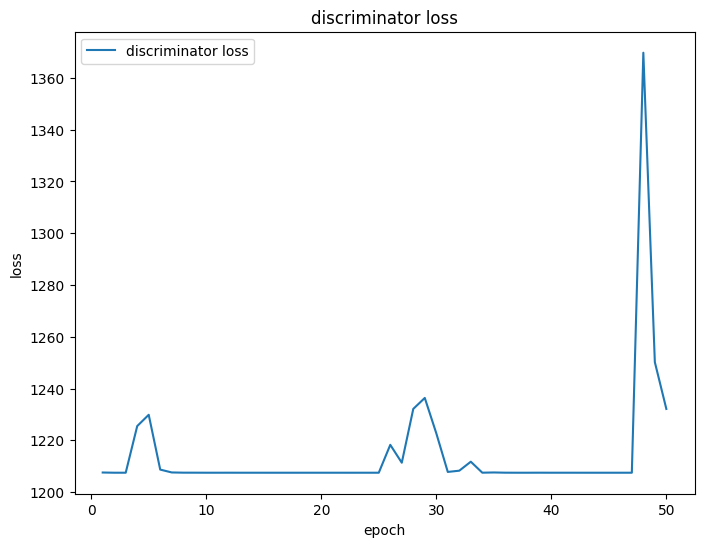

In [9]:
from mode import *
import argparse
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def str2bool(v):
    return v.lower() in ('true')

parser = argparse.ArgumentParser()
## Model specification
parser.add_argument("--input_channel", type=int, default=1)
parser.add_argument("--output_channel", type=int, default=2)
parser.add_argument("--n_feats", type=int, default=64)
parser.add_argument("--color_feat_dim", type=int, default=313)
parser.add_argument("--spatial_feat_dim", type=int, default=512)
parser.add_argument("--mem_size", type=int, default=982)
parser.add_argument("--alpha", type=float, default=0.3)
parser.add_argument("--top_k", type=int, default=256)
parser.add_argument("--color_info", type=str, default='dist', help='option should be dist or RGB')

## Data specification
parser.add_argument("--train_data_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/self_supervise_dataset/genki4k/train')
parser.add_argument("--test_data_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/self_supervise_dataset/genki4k/valid')
parser.add_argument("--data_name", type=str, default='pokemon')
parser.add_argument("--km_file_path", type=str, default='./pts_in_hull.npy')
parser.add_argument("--img_size", type=int, default=256)
parser.add_argument("--model_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/weight')
parser.add_argument("--result_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/result_images/task2')
parser.add_argument("--mem_model", type=str, default='/home/yelu/PycharmProjects/ml_minilab/weight/pokemon/memory_049.pt')
parser.add_argument("--generator_model", type=str, default='/home/yelu/PycharmProjects/ml_minilab/weight/pokemon/generator_049.pt')

## Training or test specification
parser.add_argument("--batch_size", type=int, default=4)
parser.add_argument("--lr", type=float, default=1e-4)
parser.add_argument("--epoch", type=int, default=50)
parser.add_argument("--color_thres", type=float, default=0.5)
parser.add_argument("--test_with_train", type=str2bool, default=True)
parser.add_argument("--test_freq", type=int, default=2)
parser.add_argument("--model_save_freq", type=int, default=10)
parser.add_argument("--test_only", type=str2bool, default=False)

args = parser.parse_args(args=[])
tol_epoch, loss_discriminator = train(args)
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.plot(tol_epoch, loss_discriminator, label='discriminator loss')
plt.title('discriminator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### test part

In the following part, tester will scan the test file, and the gary, real RGB and generated RGB image will be shown below. The training epoch isn't enough, so the final still have a difference with the real one, but the final result is already fine.


##----- true image -- generated image -- gray image -----##


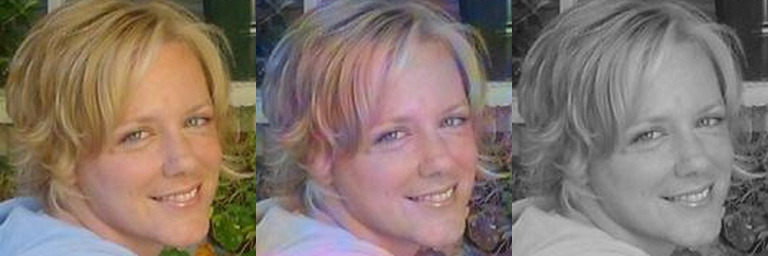

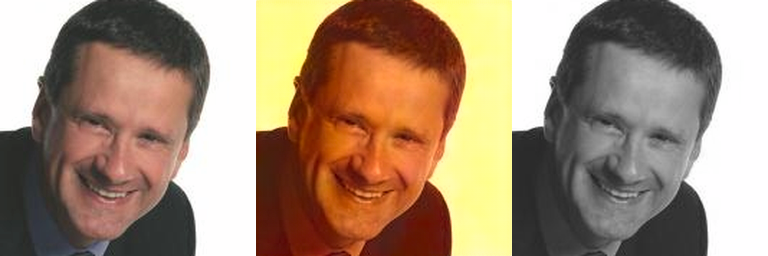

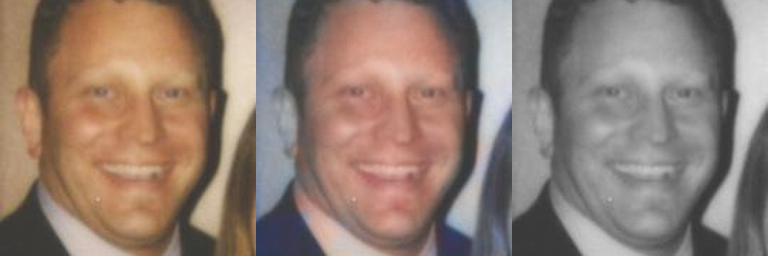

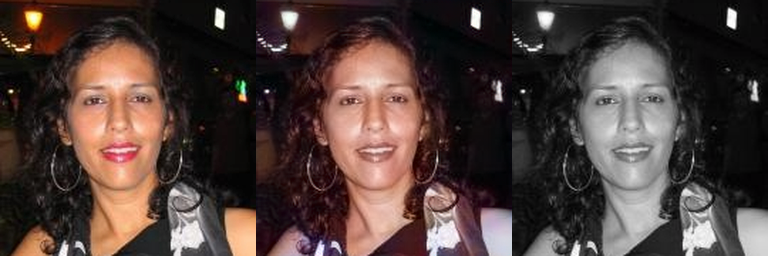

In [8]:
from mode import *
import argparse
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def str2bool(v):
    return v.lower() in ('true')

parser = argparse.ArgumentParser()
## Model specification
parser.add_argument("--input_channel", type=int, default=1)
parser.add_argument("--output_channel", type=int, default=2)
parser.add_argument("--n_feats", type=int, default=64)
parser.add_argument("--color_feat_dim", type=int, default=313)
parser.add_argument("--spatial_feat_dim", type=int, default=512)
parser.add_argument("--mem_size", type=int, default=982)
parser.add_argument("--alpha", type=float, default=0.3)
parser.add_argument("--top_k", type=int, default=256)
parser.add_argument("--color_info", type=str, default='dist', help='option should be dist or RGB')

## Data specification
parser.add_argument("--train_data_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/self_supervise_dataset/genki4k/train')
parser.add_argument("--test_data_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/self_supervise_dataset/genki4k/test')
parser.add_argument("--data_name", type=str, default='pokemon')
parser.add_argument("--km_file_path", type=str, default='./pts_in_hull.npy')
parser.add_argument("--img_size", type=int, default=256)
parser.add_argument("--model_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/weight')
parser.add_argument("--result_path", type=str, default='/home/yelu/PycharmProjects/ml_minilab/result_images/task2')
parser.add_argument("--mem_model", type=str, default='/home/yelu/PycharmProjects/ml_minilab/weight/pokemon/memory_049.pt')
parser.add_argument("--generator_model", type=str, default='/home/yelu/PycharmProjects/ml_minilab/weight/pokemon/generator_049.pt')

## Training or test specification
parser.add_argument("--batch_size", type=int, default=4)
parser.add_argument("--lr", type=float, default=1e-4)
parser.add_argument("--epoch", type=int, default=50)
parser.add_argument("--color_thres", type=float, default=0.5)
parser.add_argument("--test_with_train", type=str2bool, default=True)
parser.add_argument("--test_freq", type=int, default=2)
parser.add_argument("--model_save_freq", type=int, default=10)
parser.add_argument("--test_only", type=str2bool, default=False)

args = parser.parse_args(args=[])
rgb_imgs = test(args)

result_image_list = []
for t in range(len(rgb_imgs)):

    result_image = Image.new('RGB', (256*3, 256), color='white')
    img = rgb_imgs[t]
    h, w, c = img.shape
    stride = h // 3
    original = img[:stride, :, :]
    original = Image.fromarray(original)
    result_image.paste(original, (0, 0))
    
    result = img[stride : 2*stride, :, :]
    result = Image.fromarray(result)
    result_image.paste(result, (256, 0))
    
    gray_img = img[2*stride:, :, :]
    gray_img = Image.fromarray(gray_img)
    gray_image_rgb = gray_img.convert('RGB')
    result_image.paste(gray_image_rgb, (256*2, 0))
    
    result_image_list.append(result_image)
    
print("##----- true image ------------- generated image ---------------- gray image -----##")
for img in result_image_list:
    display(img)

# 9 Conclusions

For the result, since the dataset is mostly consisted of human face, i can do a good job on painting the face. But for the background, it still need more data to support.
To achieve a better result on the task, more categories of image is needed. Besides, training more epoch is also helpful, but due to the limited resource, I can do more experiment on this task.